# Adaptive control using `ldsctrlest`

This tutorial will be more comprehensive than the others, bringing together all of `cleosim`'s main capabilities&mdash;electrode recording, optogenetics, and latency modeling&mdash;as well as introducing more sophisticated model-based feedback control. To achieve the latter, we will use the `ldsctrlest` Python bindings to the [`ldsCtrlEst` C++ library](https://stanley-rozell.github.io/lds-ctrl-est/).

Preamble:

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt
import cleosim

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
np.random.seed(1856)

## Network setup

As in the optogenetics tutorial, we'll use a trivial network of a small neuron group biased by Poisson input spikes. Note that the opsin model is conductance-based and so depends on somewhat realistic membrane voltages. So, we'll use the exponential integrate-and-fire model, which maintains simplicity while modeling the upward membrane potential spike we need.

In [2]:
n = 2
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) - Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", 10, 100 * Hz, 2.5 * mV)

net = Network(ng, input_group)

## Coordinates, stimulation, and recording

Here we assign coordinates to the neurons and configure the optogenetic intervention and recording setup:

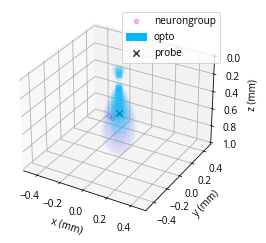

In [3]:
from cleosim.coordinates import assign_coords_rand_rect_prism, plot_neuron_positions

assign_coords_rand_rect_prism(ng, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1), zlim=(0.4, 0.6))

from cleosim.opto import *
from cleosim.electrodes import Probe, SortedSpiking

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=four_state,
    opsin_params=ChR2_four_state,
    light_model_params=default_blue,
    location=(0, 0, 0.5) * mm,
)

spikes = SortedSpiking(
    "spikes",
    perfect_detection_radius=40 * umeter,
    half_detection_radius=80 * umeter,
    save_history=True,
)
probe = Probe(
    "probe",
    coords=[0, 0, 0.5] * mm,
    signals=[spikes],
)

plot_neuron_positions(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.5, 0.5),
    ylim=(-0.5, 0.5),
    zlim=(0, 1),
    devices_to_plot=[opto, probe],
)

Looks right. Let's set up the simulation and inject the devices:

In [4]:
sim = cleosim.CLSimulator(net)
sim.inject_stimulator(opto, ng, Iopto_var_name='I')
sim.inject_recorder(probe, ng)

## Prepare controller
Our goal will be to control two neuron's firing rates simultaneously. To do this, we will use the adaptive linear technique explained in [Bolus et al., 2021 ("State-space optimal feedback control of optogenetically driven neural activity)"](https://iopscience.iop.org/article/10.1088/1741-2552/abb89c/meta).

### Fit model
Our controller needs a model of the system's dynamics, which we can obtain by fitting to training data. We will generate training data using Gaussian random walk inputs. `ldsCtrlEst` is designed for data coming from an experiment, organized into trials, so we will run the simulation repeatedly, resetting after each run. Here $u$ represents the input and $z$ the spike output.

We will intentionally use very little training data so the importance of adaptive control will become apparent later on.

In [5]:
n_trials = 5
n_samp = 100
u = []
z = []
n_u = 1  # 1-dimensional input (just one optogenetic actuator)
n_z = 2  # we'll be controlling two neurons
for trial in range(n_trials):
    u.append(np.ones((n_u, n_samp)))
    z.append(np.zeros((n_z, n_samp)))
    for k in range(1, n_samp):
        u_t = 0.975 * u[trial][:, k - 1] + 1e-1 * np.random.normal(size=n_u)
        # must be nonnegative
        u_t *= u_t >= 0
        u[trial][:, k] = u_t


The IO processor is simple enough here that we won't bother separating steps using `ProcessingBlock` objects, which is recommended for more complex scenarios where modularity is more important.

In [6]:
from cleosim.processing import LatencyIOProcessor

class TrainingStimIOP(LatencyIOProcessor):
    i_samp = 0
    i_trial = 0

    # here we just feed in the training inputs and record the outputs
    def process(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict['probe']['spikes']
        z[self.i_trial][:, self.i_samp] = z_t[:n_z]  # just first two neurons
        out = {'opto': u[self.i_trial][:, self.i_samp]}
        self.i_samp += 1
        return out, sample_time_ms

training_stim_iop = TrainingStimIOP(sample_period_ms=1)
sim.set_io_processor(training_stim_iop)

for i_trial in range(n_trials):
    training_stim_iop.i_trial = i_trial
    training_stim_iop.i_samp = 0
    sim.run(n_samp*ms)
    sim.reset()

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


Now we have `u` and `z` in the form we need for `ldsctrlest`'s fitting functions: `n_trial`-length lists of `n` by `n_samp` arrays. We will now fit Gaussian linear dynamical systems using the SSID algorithm. See [the documentation](https://stanley-rozell.github.io/lds-ctrl-est/) for more detailed explanations.

In [7]:
import ldsctrlest as lds
import ldsctrlest.gaussian as glds
n_x_fit = 2  # latent dimensionality of system
n_h = 50  # size of block Hankel data matrix
dt = 0.001  # timestep (in seconds)
u_train = lds.UniformMatrixList(u, free_dim=2)
z_train = lds.UniformMatrixList(z, free_dim=2)
ssid = glds.FitSSID(n_x_fit, n_h, dt, u_train, z_train)
fit, sing_vals = ssid.Run(lds.SSIDWt.kMOESP)

### Design controller

#### LQR optimal control

We now use the fit parameters to create the controller system and set additional parameters. The feedback gain, $ K_c $, is especially important, determining how the controller responds to the current "error"&mdash;the difference between where the system is (estimated to be) now and where we want it to be. The field of optimal control deals with how to design the controller so as to minimize a cost function reflecting what we care about.

With a linear system (obtained from the fitting procedure above) and quadratic cost function $L$

$$ L = \frac{1}{2} x^T Q x + \frac{1}{2} u^T R u $$

we can use the closed-form optimal solution called the Linear Quadratic Regulator (LQR).

$$ K = R^{-1}B^T P \quad\quad u = -Kx$$

The $P$ matrix is obtained by numerically solving the algebraic Riccati equation:

$$ PA + A^T P + Q - PB^{-1}B^TP = 0 $$

In [8]:
fit_sys = glds.System(fit)
# upper and lower bounds on control signal (optic fiber light intensity)
u_lb = 0  # mW/mm2
u_ub = 30  # mW/mm2
controller = glds.Controller(fit_sys, u_lb, u_ub)
# careful not to use this since anymore since controller made a copy
del fit_sys

from scipy.linalg import solve_discrete_are
# cost matrices
Q_cost = 1e-6 * np.eye(n_x_fit)  # reflects how much we care about state error
R_cost = 1e-2 * np.eye(n_u)  # reflects how much we care about minimizing the stimulus
P = solve_discrete_are(controller.sys.A, controller.sys.B, Q_cost, R_cost)
controller.Kc = np.linalg.inv(R_cost) @ controller.sys.B.T @ P

#### Adaptive control

Not only will our controller be optimal, but it will be *adaptive*, capable of inferring state beyond our static, linear model and thus able to account for unmodeled disturbances and noise:

In [9]:
controller.sys.do_adapt_m = True  # enable adaptive disturbance estimation
# set covariance for the disturbance state μ
# larger values mean the system more readily ascribes changes to unmodeled disturbance 
controller.sys.Q_m = 1e-2 * np.eye(n_x_fit)
controller.control_type = lds.kControlTypeAdaptM  # enable adaptive control
controller.Print()

We now configure the `IOProcessor` to use our controller and to allow us to turn on and off the controller:

In [10]:
class CtrlLoop(LatencyIOProcessor):
    def __init__(self, samp_period_ms, controller, y_ref: callable):
        super().__init__(samp_period_ms)
        self.controller = controller
        self.sys = controller.sys
        self.y_ref = y_ref
        self.do_control = False  # allows us to turn on and off control
        self.processing = "parallel"

        # for post hoc visualization/analysis:
        self.u = np.empty((n_u, 0))
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

    def process(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict["probe"]["spikes"]
        z_t = z_t[:n_z].reshape((-1, 1))  # just first n_z neurons
        self.controller.y_ref = self.y_ref(sample_time_ms)

        u_t = self.controller.ControlOutputReference(z_t, do_control=self.do_control)
        out = {opto.name: u_t}

        # record variables from this timestep
        self.u = np.hstack([self.u, u_t])
        self.y_hat = np.hstack([self.y_hat, self.sys.y])
        self.x_hat = np.hstack([self.x_hat, self.sys.x])
        self.z = np.hstack((self.z, z_t))

        return out, sample_time_ms + 3  # 3 ms delay


y_ref = 200 * dt  # target rate in Hz
ctrl_loop = CtrlLoop(
    samp_period_ms=1, controller=controller, y_ref=lambda t: np.ones((n_z, 1)) * y_ref
)

## Run the experiment

We'll now run the simulation in three phases to compare:
1. no control
2. standard LQR control
3. adaptive LQR control

In [11]:
sim.set_io_processor(ctrl_loop)
T0 = 100
sim.run(T0*ms)

ctrl_loop.do_control = True
# ctrl_system.Q_m = np.zeros((n_x_fit, n_x_fit))
ctrl_loop.sys.do_adapt_m = False
T1 = 350
sim.run(T1*ms)

# ctrl_system.Q_m = 1e-2 * np.eye(n_x_fit)
ctrl_loop.sys.do_adapt_m = True
T2 = 350
sim.run(T2*ms)
T = T0 + T1 + T2

WARNING    'dt' is an internal variable of group 'synapses_opto_neurongroup', but also exists in the run namespace with the value 0.001. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Now we plot the results to see how well the controller was able to match the desired firing rate:

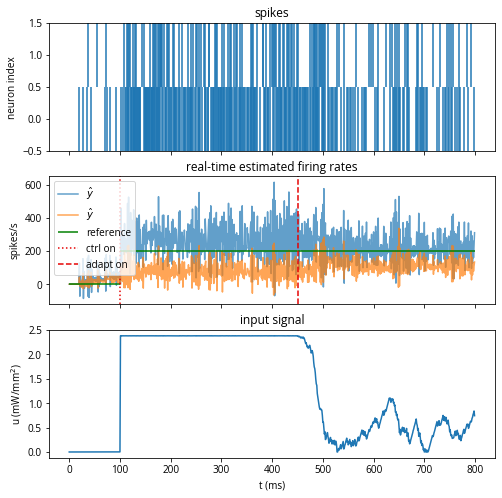

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.eventplot(spikes.t_ms[:, np.newaxis], lineoffsets=spikes.i[:, np.newaxis])
ax1.set(ylabel='neuron index', ylim=(-.5, 1.5), title='spikes')
ax2.set(ylabel='spikes/s', title='real-time estimated firing rates')
ax2.plot(ctrl_loop.y_hat.T/dt, alpha=0.7, label='$\hat{y}$')
ax2.hlines(y_ref/dt, 100, T, color='green', label='reference')
ax2.hlines(0, 0, 100, color='green')
ax2.axvline(T0, c='xkcd:red', linestyle=':', label='ctrl on')
ax2.axvline(T0+T1, c='xkcd:red', linestyle='--', label='adapt on')
ax2.legend()
ax3.plot(range(T), ctrl_loop.u.T)
ax3.set(xlabel='t (ms)', ylabel='u (mW/mm$^2$)', title='input signal');

Looks all right, but in addition to the system's estimated firing rate let's count the spikes over the control period to see how well we hit the target on average:

In [13]:
print("Results (spikes/second):")
print('baseline =', np.sum(ctrl_loop.z[:, :T0], axis=1)/(T0/1000))
print('target =', [y_ref*1000, y_ref*1000])
print('static achieved =', (np.sum(ctrl_loop.z[:, T0:T0+T1], axis=1)/(T1/1000)).round(1))
print('adaptive achieved =', (np.sum(ctrl_loop.z[:, T0+T1:T], axis=1)/(T2/1000)).round(1))

Results (spikes/second):
baseline = [80. 30.]
target = [200.0, 200.0]
static achieved = [500. 220.]
adaptive achieved = [268.6 128.6]


As we could expect, we weren't able to maintain the target firing rate with both neurons simultaneously since one was exposed to more light than the other. However, the controller was able to achieve a degree of balance, and did so slightly better with adaptive control enabled.

## Conclusion
As a recap, in this tutorial we've seen how to:
- inject optogenetic stimulation into an existing Brian network
- inject an electrode into an existing Brian network to record spikes
- generate training data and fit a Gaussian linear dynamical system to the spiking output using `ldsctrlest`
- configure an adaptive `ldsctrlest` controller based on that linear system and design optimal gains
- use that controller in running a complete simulated feedback control experiment

## Appendix

To see if the system's online estimation of firing rates is reasonable, we compute a Gaussian-smoothed version with a 25-ms standard deviation:

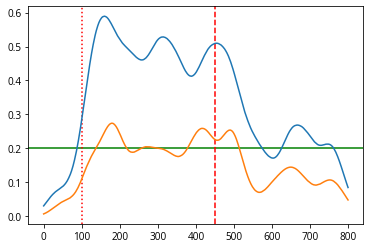

In [14]:
from scipy.stats import norm
kernel = norm.pdf(np.linspace(-75, 75, 151), scale=25)  # 25-ms Gaussian window
smoothed1 = np.convolve(ctrl_loop.z[0, :], kernel, mode='same')
smoothed2 = np.convolve(ctrl_loop.z[1, :], kernel, mode='same')
plt.axhline(y_ref, c='g')
plt.axvline(T0, c='r', ls=':')
plt.axvline(T0+T1, c='r', ls='--')
plt.plot(smoothed1)
plt.plot(smoothed2);